In [25]:
import re, copy, pickle
from pathlib import Path

import spacy, pandas as pd
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore, LdaModel
import pyLDAvis as vis
import pyLDAvis.gensim_models as gensimvis

vis.enable_notebook()

# spacy internal setup
if not 'nlp' in locals():
    model_loaded: bool = False
    while not model_loaded:
        # we keep trying until this works...
        try:
            print("attempting to load model")
            # attempt to load the spacy model
            nlp: spacy.Language = spacy.load("en_core_web_sm")
            print("model loaded successfully")
            model_loaded = True
        except BaseException as e:
            print("model failed to load")
            # if we fail to load the model, we are going to make
            # sure the package is installed...
            from spacy.cli import download
            download("en_core_web_sm")
            # then loop around and try to load it again

In [2]:
path_root: Path = Path(".").resolve()

In [3]:
md_text_raw: str = path_root.joinpath("moby_dick.txt").read_text('utf-8')

# Preprocess the text

In [4]:
# DEFINE SOME USEFUL VARIABLES FOR PREPROCESSING
# utf-8 codes for some characters in the text
dq_op: str = "\u201C" # double quotes open
dq_cl: str = "\u201D" # double quotes close
sq_op: str = "\u2018" # single quote open
sq_cl: str = "\u2019" # single quote close
under: str = "\u005F" # underscore
hyphe: str = "\u002D" # hyphen/minus
mdash: str = "\u2014" # em dash

In [5]:
# replace newlines and carriage returns with whitespace
md_text: str = re.sub("[\n\r]", " ", md_text_raw)
# remove everything before the first chapter
md_text = re.sub("[\w\W]*(?=CHAPTER 1\. Loomings)", "", md_text, count=1)
# remove everything after the end of the epilogue
md_text = re.sub("\s*(\*\*\* END)[\w\W]+", "", md_text, count=1)
# there are some weird embedded books in the middle of the text
# first we remove the in-betweens of the embedded books
md_text = re.sub("(Thus ends BOOK[\w\W]+?)([\w\W]+?BOOK[\w\W]+?)(?=\s\s)", "", md_text)
# then we get rid of the chapter headings of the embedded books
md_text = re.sub("BOOK\s+[IV]+([\w\W]+?(?=CHAPTER)CHAPTER\s+[IV\d]+\.\s+[\w\W]+?(?=\.)\.)?", "", md_text)
# CLEANING UP IMPORTANT UTF-8 CHARACTERS
# replace all utf single quotes with ascii single quotes
md_text = re.sub(f"{sq_op}|{sq_cl}", "\'", md_text)
# replace all utf double quotes with ascii double quotes
md_text = re.sub(f"{dq_op}|{dq_cl}", "\"", md_text)
# replace utf underscores with ascii
md_text = re.sub(f"{under}", "_", md_text)
# replace utf hyphens with ascii
md_text = re.sub(f"{hyphe}", "-", md_text)
# replace utf em dash with hyphen
md_text = re.sub(f"{mdash}", "-", md_text)
# next (and I don't know if this is a good idea...) we're going to replace
# all punctuation that is NOT a:
# . or ! or ? or whitespace or "
md_text = re.sub("[^\w\d\s\.\"?!]", " ", md_text)
# finally, we want to replace repeated whitespace with single whitespace
md_text = re.sub("\s+", " ", md_text)

<>:4: DeprecationWarning: invalid escape sequence '\w'
<>:6: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\w'
<>:11: DeprecationWarning: invalid escape sequence '\s'
<>:26: DeprecationWarning: invalid escape sequence '\w'
<>:28: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\w'
<>:6: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\w'
<>:11: DeprecationWarning: invalid escape sequence '\s'
<>:26: DeprecationWarning: invalid escape sequence '\w'
<>:28: DeprecationWarning: invalid escape sequence '\s'
/var/folders/cy/b9frshpd6y10jtcxx8hyv2yw0000gn/T/ipykernel_2884/4172870422.py:4: DeprecationWarning: invalid escape sequence '\w'
  md_text = re.sub("[\w\W]*(?=CHAPTER 1\. Loomings)", "", md_text, count=1)
/var/folders/cy/b9frshpd6y10jtcxx8hyv2yw0000gn/T/ipykernel_2884/4172870422.py:6: DeprecationWarning: invalid escape sequence '\s

In [6]:
# defining a function to contain intermediate variables
def split_chapters(text: str) -> dict[str, str]:
    # build a list of the chapter titles and their contents
    list_results: list[str] = [result.strip() for result in re.split("(CHAPTER\s\d+\.\s)|(Epilogue)", text) if result != "" and result is not None]
    # use that list to create a dictionary that is {chapter_title: chapter_content}
    return {x: list_results[i+1] for i, x in enumerate(list_results) if re.match("(CHAPTER\s\d+\.)|(Epilogue)", x)}
# run the processed text through the chapter splitter
dict_chapters: dict[str, str] = split_chapters(md_text)
#for i in dict_chapters:
    #print(i, dict_chapters[i])

<>:4: DeprecationWarning: invalid escape sequence '\s'
<>:6: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\s'
<>:6: DeprecationWarning: invalid escape sequence '\s'
/var/folders/cy/b9frshpd6y10jtcxx8hyv2yw0000gn/T/ipykernel_2884/3233331185.py:4: DeprecationWarning: invalid escape sequence '\s'
  list_results: list[str] = [result.strip() for result in re.split("(CHAPTER\s\d+\.\s)|(Epilogue)", text) if result != "" and result is not None]
/var/folders/cy/b9frshpd6y10jtcxx8hyv2yw0000gn/T/ipykernel_2884/3233331185.py:6: DeprecationWarning: invalid escape sequence '\s'
  return {x: list_results[i+1] for i, x in enumerate(list_results) if re.match("(CHAPTER\s\d+\.)|(Epilogue)", x)}


In [7]:
# instantiate the spacy nlp object
# this object contains all of the functionality for
# turning a string or list of strings into spacy "Documents"
"""we no longer need to do the following line as it's loaded with the imports"""
# nlp: spacy.Language = spacy.load("en_core_web_sm")

# our book is a little too long for the default
# processing limit so we increase it slightly
nlp.max_length = 1200000

In [8]:
# let spacy process the full text
# this produces a "Document"
# the document is a tokenized representation of the full
# text with a bunch of extra information attached to the tokens
doc = nlp(md_text)

In [9]:
# spacy stores things like parts of speech as integer tags
# we can use this reverse lookup table to get the string label
lookup: dict[int, str] = {y: x for x, y in spacy.symbols.IDS.items()}

In [10]:
nounsPer = []
verbsPer = []
wordsPer = []

for ch in dict_chapters:
    #print(dict_chapters[ch])
    temp = nlp(dict_chapters[ch])
    wordsPer.append(len(temp))
    
    noun_alikes:  list[str] = [x.text for x in temp if lookup[x.pos] in {"NOUN", "PROPN", "PRON"}]
    nouns: pd.Series = pd.Series(noun_alikes)
    nouns_counts: pd.Series = nouns.value_counts()
    nounsPer.append(len(nouns_counts))
    
    verb_alikes:  list[str] = [x.text for x in temp if lookup[x.pos] in {"VERB"}]
    verbs: pd.Series = pd.Series(verb_alikes)
    verbs_counts: pd.Series = verbs.value_counts()
    verbsPer.append(len(verbs_counts))
    #print(nouns_counts)
    #print(len(nouns_counts))

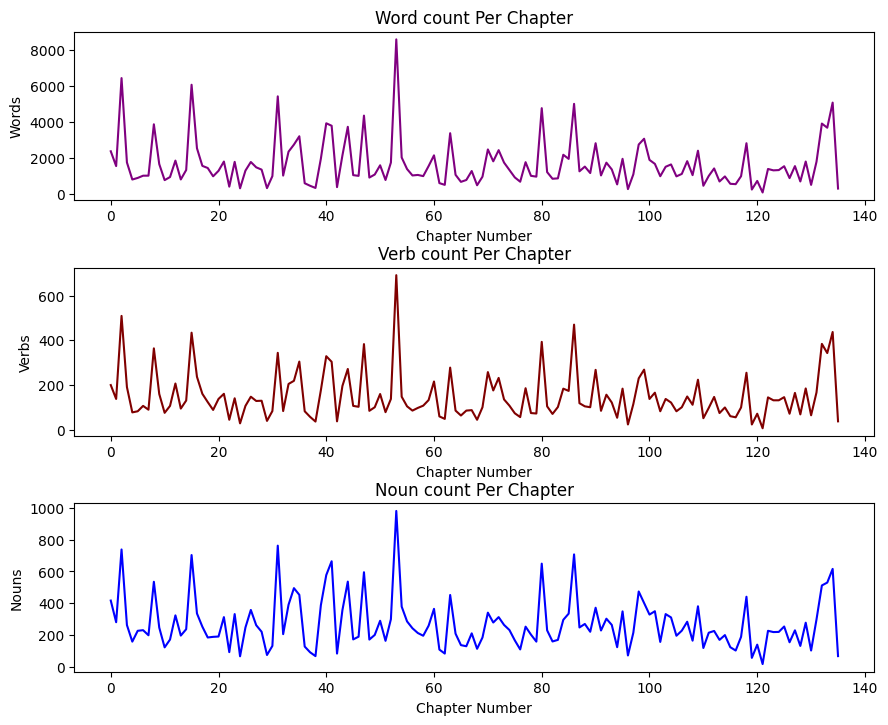

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
x = range(0,136)

plt.subplot(3, 1, 1)
plt.plot(x, wordsPer, color ='purple')
plt.xlabel('Chapter Number')
plt.ylabel('Words')
plt.title('Word count Per Chapter')

plt.subplot(3, 1, 2)
plt.plot(x, verbsPer, color ='maroon')
plt.xlabel('Chapter Number')
plt.ylabel('Verbs')
plt.title('Verb count Per Chapter')

plt.subplot(3, 1, 3)
plt.plot(x, nounsPer, color ='blue')
plt.xlabel('Chapter Number')
plt.ylabel('Nouns')
plt.title('Noun count Per Chapter')
plt.show()

In [12]:
texts: list[list[str]] = [
    [
        token.lemma_ for token in sentence.as_doc() if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
    ]
    for sentence in doc.sents
]

id2word = corpora.Dictionary(texts)

corpus = [id2word.doc2bow(text) for text in texts]

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

doc_lda = lda_model[corpus]

In [13]:
gensimvis.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.355199 -0.095386       1        1  15.553566
2      0.029457  0.016759       2        1  14.850505
17     0.079721  0.330045       3        1  14.334524
7     -0.003916 -0.011210       4        1  11.881511
1     -0.029921 -0.019299       5        1   7.039438
16    -0.027611 -0.019265       6        1   6.245958
4     -0.027145 -0.019095       7        1   5.539749
12    -0.031705 -0.019174       8        1   5.501880
13    -0.032836 -0.018550       9        1   2.897009
0     -0.032269 -0.016426      10        1   2.319851
8     -0.032316 -0.016458      11        1   2.141313
6     -0.029703 -0.014050      12        1   2.071052
14    -0.030560 -0.014752      13        1   1.978315
19    -0.031185 -0.015300      14        1   1.957270
11    -0.029890 -0.014212      15        1   1.734607
15    -0.026576 -0.011743      16        1   1.048847
10    -0.027018 -0.012055      17        1   0.883532
18    -0.024097 -0.010058      18        1   0.859446
5     -0.025661 -0.011116      19        1   0.723547
9     -0.021967 -0.008654      20        1   0.438078, topic_info=       Term         Freq        Total Category  logprob  loglift
52        s  8248.000000  8248.000000  Default  30.0000  30.0000
126    like  2402.000000  2402.000000  Default  29.0000  29.0000
53      sea  1831.000000  1831.000000  Default  28.0000  28.0000
218     man  1566.000000  1566.000000  Default  27.0000  27.0000
69     ship  2301.000000  2301.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
1806  shall     0.023361     2.341121  Topic20  -9.8076   0.8232
1520   boat     0.023362     2.345211  Topic20  -9.8076   0.8215
807    said     0.023361     2.341792  Topic20  -9.8076   0.8229
2905  Whale     0.023360     2.342039  Topic20  -9.8077   0.8228
644   whale     0.023360     2.346596  Topic20  -9.8077   0.8208

[929 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
223       3  0.962282  American
372       5  0.993907   Captain
80        7  0.981195    Indian
210      14  0.962102       Let
110       3  0.991090      Look
...     ...       ...       ...
582       4  0.986656   whaling
276       3  0.973119     winds
17        2  0.996438     world
18        2  0.995273     years
179      14  0.957599    yonder

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 18, 8, 2, 17, 5, 13, 14, 1, 9, 7, 15, 20, 12, 16, 11, 19, 6, 10])

In [16]:
models: list[LdaModel] = []
corpii: list[list[tuple[int, int]]] = []
gsdicts: list[corpora.Dictionary] = []

for chap_num, chap_text in dict_chapters.items():
    
    print(f"processing {chap_num}")
    
    texts: list[list[str]] = [
        [
            token.lemma_ for token in sentence.as_doc() if
            not token.is_stop
            and not token.is_punct
            and not token.is_digit
        ]
        for sentence in doc.sents
    ]
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=20, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    doc_lda = lda_model[corpus]
    
    models.append(copy.copy(lda_model))
    corpii.append(copy.copy(corpus))
    gsdicts.append(copy.copy(id2word))
    pass

processing CHAPTER 1.
processing CHAPTER 2.
processing CHAPTER 3.
processing CHAPTER 4.
processing CHAPTER 5.
processing CHAPTER 6.
processing CHAPTER 7.
processing CHAPTER 8.
processing CHAPTER 9.
processing CHAPTER 10.
processing CHAPTER 11.
processing CHAPTER 12.
processing CHAPTER 13.
processing CHAPTER 14.
processing CHAPTER 15.
processing CHAPTER 16.
processing CHAPTER 17.
processing CHAPTER 18.
processing CHAPTER 19.
processing CHAPTER 20.
processing CHAPTER 21.
processing CHAPTER 22.
processing CHAPTER 23.
processing CHAPTER 24.
processing CHAPTER 25.
processing CHAPTER 26.
processing CHAPTER 27.
processing CHAPTER 28.
processing CHAPTER 29.
processing CHAPTER 30.
processing CHAPTER 31.
processing CHAPTER 32.
processing CHAPTER 33.
processing CHAPTER 34.
processing CHAPTER 35.
processing CHAPTER 36.
processing CHAPTER 37.
processing CHAPTER 38.
processing CHAPTER 39.
processing CHAPTER 40.
processing CHAPTER 41.
processing CHAPTER 42.
processing CHAPTER 43.
processing CHAPTER 4

In [26]:
path_models: Path = Path("models")
for i, chap in enumerate(dict_chapters.keys()):
    path_chap: Path = path_models.joinpath(chap.replace(" ", "").replace(".", ""))
    path_chap.mkdir(parents=True, exist_ok=True)
    path_file_model: Path = path_chap.joinpath("model.pickle")
    path_file_corpus: Path = path_chap.joinpath("corpus.pickle")
    path_file_gsdict: Path = path_chap.joinpath("gsdict.pickle")
    with open(path_file_model, 'wb') as file:
        pickle.dump(models[i], file)
    with open(path_file_corpus, 'wb') as file:
        pickle.dump(corpii[i], file)
    with open(path_file_gsdict, 'wb') as file:
        pickle.dump(gsdicts[i], file)
    